8-Puzzle Problem Solver using Best First Search
----------------------------------------------

Enter initial state (9 numbers with 0 as the blank space):
Example: 1 2 3 4 0 5 6 7 8

Enter goal state (9 numbers with 0 as the blank space):
Example: 1 2 3 4 5 6 7 8 0

Choose heuristic:
1. Manhattan Distance
2. Misplaced Tiles

Solving 8-puzzle with Best First Search...

Solution found!

Solution path:

Step 0:
1 2 3
4 5 6
0 7 8

Step 1:
1 2 3
4 5 6
7 0 8

Step 2:
1 2 3
4 5 6
7 8 0

Total steps: 2


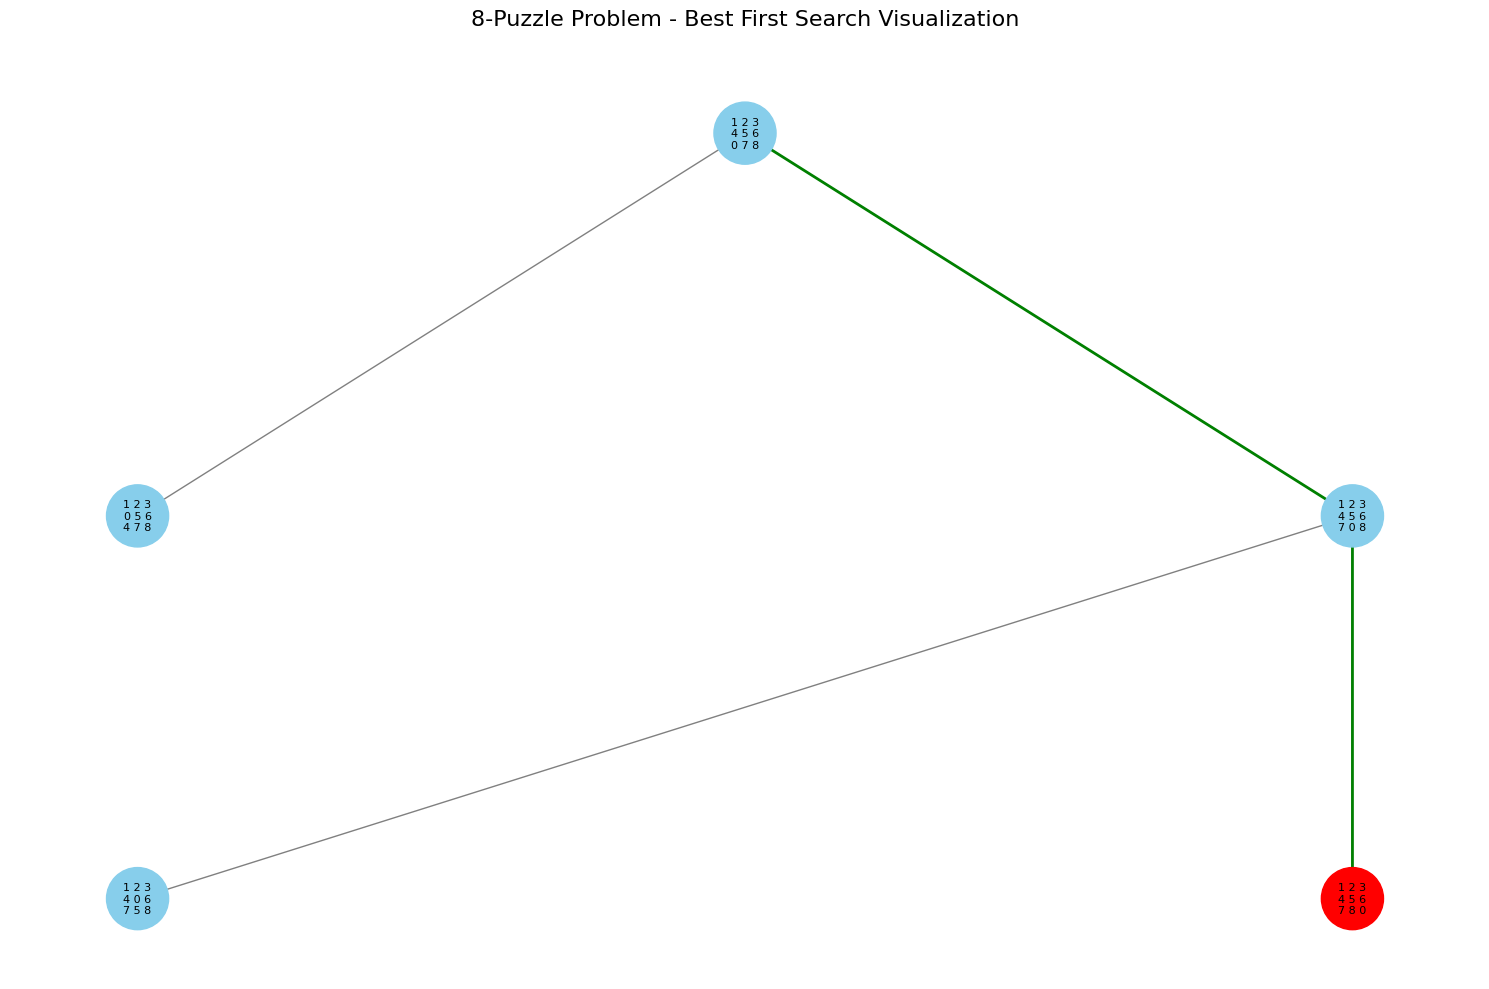

Thank you for using the 8-Puzzle Problem Solver!


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import numpy as np
from itertools import count

# Counter for tie-breaking in the priority queue
unique_counter = count()

def create_initial_state(puzzle_input):
    """Convert a list of 9 numbers (0 represents the empty space) to a 3x3 grid"""
    return tuple(puzzle_input)

def get_blank_position(state):
    """Find the position of the blank (0) in the puzzle"""
    return state.index(0)

def manhattan_distance(state, goal_state):
    """Calculate the Manhattan distance heuristic"""
    distance = 0
    size = 3  # 3x3 grid
    
    for i in range(1, 9):  # For each tile (excluding the blank)
        if i in state:
            # Current position
            curr_pos = state.index(i)
            curr_row, curr_col = curr_pos // size, curr_pos % size
            
            # Goal position
            goal_pos = goal_state.index(i)
            goal_row, goal_col = goal_pos // size, goal_pos % size
            
            # Add Manhattan distance
            distance += abs(curr_row - goal_row) + abs(curr_col - goal_col)
    
    return distance

def misplaced_tiles(state, goal_state):
    """Calculate the number of misplaced tiles heuristic"""
    return sum(1 for i in range(9) if state[i] != goal_state[i] and state[i] != 0)

def is_goal_state(state, goal_state):
    """Check if the current state is the goal state"""
    return state == goal_state

def get_neighbors(state):
    """Generate all possible next states by moving the blank"""
    neighbors = []
    blank_pos = get_blank_position(state)
    
    # Convert to row, col coordinates
    row, col = blank_pos // 3, blank_pos % 3
    
    # Possible moves: up, down, left, right
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    for move_row, move_col in moves:
        new_row, new_col = row + move_row, col + move_col
        
        # Check if the move is valid
        if 0 <= new_row < 3 and 0 <= new_col < 3:
            new_blank_pos = new_row * 3 + new_col
            
            # Create a new state by swapping the blank with the adjacent tile
            new_state = list(state)
            new_state[blank_pos], new_state[new_blank_pos] = new_state[new_blank_pos], new_state[blank_pos]
            neighbors.append(tuple(new_state))
    
    return neighbors

def best_first_search(initial_state, goal_state, heuristic_func):
    """Implement Best First Search using a priority queue"""
    # Initialize the priority queue with the initial state
    open_set = [(heuristic_func(initial_state, goal_state), next(unique_counter), initial_state)]
    closed_set = set()
    
    # For visualization
    graph = nx.DiGraph()
    graph.add_node(initial_state, subset=0)
    levels = {initial_state: 0}
    parent = {}
    
    while open_set:
        # Get the state with the lowest heuristic value
        _, _, current_state = heapq.heappop(open_set)
        
        # If we reached the goal, reconstruct the path
        if is_goal_state(current_state, goal_state):
            path = []
            temp = current_state
            while temp in parent:
                path.append(temp)
                temp = parent[temp]
            path.append(initial_state)
            path.reverse()
            
            return True, path, graph, levels, current_state
        
        # Mark the current state as visited
        closed_set.add(current_state)
        
        # Generate neighbors
        for neighbor in get_neighbors(current_state):
            if neighbor in closed_set:
                continue
            
            # Add the neighbor to the open set if not already there
            h_value = heuristic_func(neighbor, goal_state)
            
            # Check if this neighbor is new
            is_new = True
            for _, _, state in open_set:
                if state == neighbor:
                    is_new = False
                    break
            
            if is_new:
                heapq.heappush(open_set, (h_value, next(unique_counter), neighbor))
                parent[neighbor] = current_state
                
                # Add to graph for visualization
                level = levels[current_state] + 1
                graph.add_node(neighbor, subset=level)
                graph.add_edge(current_state, neighbor)
                levels[neighbor] = level
    
    return False, None, graph, levels, None

def draw_tree(graph, goal_state=None, path=None):
    """Draw the search tree visualization"""
    plt.figure(figsize=(15, 10))
    
    # Get the levels for each node
    levels = nx.get_node_attributes(graph, 'subset')
    
    # Create a hierarchical layout
    pos = {}
    nodes_by_level = {}

    # Group nodes by level
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)
    
    # Calculate positions for each node
    max_nodes_in_level = max(len(nodes) for nodes in nodes_by_level.values()) if nodes_by_level else 0
    for level, nodes in nodes_by_level.items():
        n_nodes = len(nodes)
        for i, node in enumerate(nodes):
            # Center the nodes at each level
            x = (i - (n_nodes - 1)/2) * (15.0/max(1, max_nodes_in_level))
            y = -level * 1.5  # Negative to grow downward
            pos[node] = (x, y)
    
    # Draw all edges first (default gray)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', arrows=True,
                           arrowsize=20, arrowstyle='->')

    # Highlight the solution path if provided
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, 
                               edge_color='green', width=2,
                               arrows=True, arrowsize=20, arrowstyle='->')

    # Default node color
    node_colors = ['skyblue' if node != goal_state else 'red' for node in graph.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, 
                           node_size=2000, node_shape='o')

    # Draw labels with formatted puzzle representation
    labels = {}
    for node in graph.nodes():
        # Format the 3x3 grid as a string
        grid_str = "\n".join([
            " ".join(str(node[i*3 + j]) for j in range(3))
            for i in range(3)
        ])
        labels[node] = grid_str
        
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)
    
    plt.title("8-Puzzle Problem - Best First Search Visualization", pad=20, size=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def print_solution_steps(path):
    """Print the solution steps"""
    if not path:
        print("No solution found.")
        return
        
    print("\nSolution path:")
    for i, state in enumerate(path):
        grid = [state[i*3:(i+1)*3] for i in range(3)]
        print(f"\nStep {i}:")
        for row in grid:
            print(" ".join(str(tile) for tile in row))
            
    print(f"\nTotal steps: {len(path) - 1}")

def main():
    print("8-Puzzle Problem Solver using Best First Search")
    print("----------------------------------------------")
    
    while True:
        try:
            print("\nEnter initial state (9 numbers with 0 as the blank space):")
            print("Example: 1 2 3 4 0 5 6 7 8")
            initial_input = input("Initial state: ")
            initial_state = create_initial_state([int(x) for x in initial_input.split()])
            
            print("\nEnter goal state (9 numbers with 0 as the blank space):")
            print("Example: 1 2 3 4 5 6 7 8 0")
            goal_input = input("Goal state: ")
            goal_state = create_initial_state([int(x) for x in goal_input.split()])
            
            print("\nChoose heuristic:")
            print("1. Manhattan Distance")
            print("2. Misplaced Tiles")
            heuristic_choice = int(input("Enter choice (1/2): "))
            
            heuristic = manhattan_distance if heuristic_choice == 1 else misplaced_tiles
            
            print(f"\nSolving 8-puzzle with Best First Search...")
            solved, path, graph, levels, goal = best_first_search(initial_state, goal_state, heuristic)
            
            if solved:
                print("\nSolution found!")
                print_solution_steps(path)
                draw_tree(graph, goal_state=goal, path=path)
            else:
                print("\nNo solution could be found.")
                draw_tree(graph)
            
            choice = input("\nWould you like to solve another problem? (yes/no): ").lower()
            if choice not in ['yes', 'y']:
                print("Thank you for using the 8-Puzzle Problem Solver!")
                break
                
        except ValueError as e:
            print(f"Error: {e}. Please enter valid numbers.")
        except Exception as e:
            print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()